## DEM Download

**Script to get DEMs for an area of interest**

*Prepared by Curtis Smith curtis.smith@stantec.com*

*updated to handle user defined data 11/9/2021*

In [1]:
import os

In [2]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [3]:
import geopandas as gpd
import sys, copy, shutil, subprocess
import pathlib as pl
import fiona
import descartes
import json
import numpy as np
import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext autoreload
# %autoreload 2
sys.path.append('..')
from src.grass_functions import*
from src.process_inputs import*

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#address ssl issue
home = pl.Path(os.getcwd())
ssl_path = str(home.parent/'docker')
os.environ['SSL_CERT_DIR'] = ssl_path
pem = '/etc/ssl/certs/stantec-ca.crt'

import urllib3 
http = urllib3.PoolManager( cert_reqs='CERT_REQUIRED', ca_certs=pem)

### Set parameters

In [5]:
#set project variables
Project_Area = 'kc_debug'
GRASS_GIS_Projection = projection = '5070' #set to None if you want to use the DEM's original projection
res = '10m'

## Set variables analysis
source = 'wbd' #or user-defined
data_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '102701040607' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = None #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 2000
auto_delete = False

In [6]:
if data_scale.find('HUC') >= 0:
    huc_level = re.findall("[0-9]+",data_scale)[0]
    if huc_level == str(len(select_data)):
        huc_digys = huc_level
    else:
        huc_digys = huc_level
        select_data = select_data[:int(huc_digys)]

In [7]:
parent_dir = pl.Path(os.getcwd()).parent/'data'

## Paths:
vector_parent_dir = parent_dir/'Vectors'
current_dir = pl.Path(os.getcwd())
vector_dir = parent_dir/'Vectors'/Project_Area
if not os.path.exists(vector_dir):
    os.makedirs(vector_dir)
raster_dir = parent_dir/'Rasters'/Project_Area
if not os.path.exists(raster_dir):
    os.makedirs(raster_dir)
git_data_repo = current_dir/'data_repository'

if input_shp_name:
    input_shp = vector_dir/input_shp_name
outputs_dir =parent_dir/'Rasters'/Project_Area/'dem'

### Get area of interest

In [9]:
#prep work
assert source in ['wbd','user-defined']
if source == 'wbd':
    wbd = nhd_download(select_data,vector_dir,docker=pem)

    #read in HUC12s vector file from NHD
    local_huc4 = gpd.read_file(vector_dir/wbd, layer='WBDHU{}'.format(huc_digys))

    #reformat fields to handle disparate USGS data formats
    local_huc4 = lower_pd_cols(local_huc4.copy())
    if to_headwaters:
        ## function to get most downstream HUC12 if HUC10 or HUC8 is entered
        select_data = get_downstream_huc12(select_data,local_huc4)

        #get all upstream HUC12s
        local_huc12 = local_huc4.loc[local_huc4['huc12'] == select_data]
        upstream_list = get_upstream_extent_usgs(select_data) #selected huc12
        aoi = local_huc4.loc[local_huc4['huc12'].isin(upstream_list) == True]
    else:
        aoi = local_huc4.loc[local_huc4['huc{}'.format(huc_digys)] == select_data]
        local_huc12 = None
else:
    shp = gpd.read_file(input_shp)
    shp = shp.rename({'HUC10_mod':'perim'},axis=1)
    aoi = shp.loc[shp[data_scale] == select_data]
    local_huc12 = None
#save to vector for later analysis
huc_path = vector_dir/'{0}_{1}_aoi.geojson'.format(Project_Area,select_data)
#fix topological errors
aoi['geometry'] = aoi.buffer(0) 
aoi.to_crs(epsg=projection).to_file(str(huc_path),driver="GeoJSON")

gdb is already downloaded


/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")

[2025-08-13 18:47:13,443] [WARNING] [geodataframe] : Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


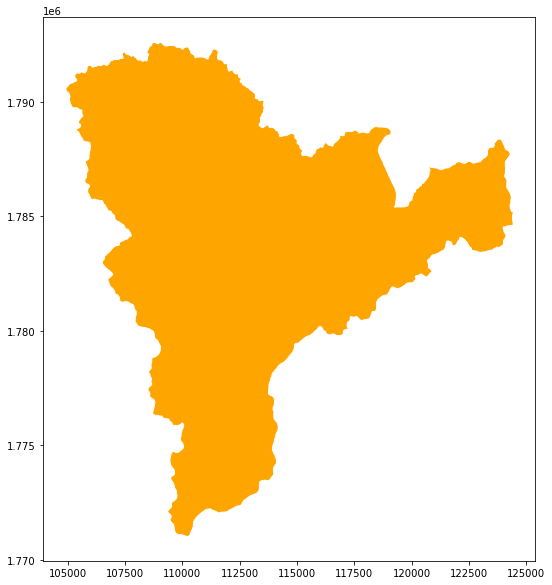

In [11]:
#plot
fix1, ax1 = plt.subplots(figsize=(30,10))
aoi.plot(ax = ax1, color = 'orange', edgecolor = 'white')
plt.show()

### Gather best DEM

In [12]:
##intersect with web service to get dem links
gdf_dem, aoi_coverage_buffer = tnm_coverage(aoi,desired_resolution=res, buffer = buffer, minimum_coverage = 0.8) 

Best available DEM is 10m
coverage is 100.0 percent


In [13]:
#reduce to only where buffer intersects tiles
gdf_dem_reduced = gpd.sjoin(gdf_dem,gpd.GeoDataFrame(geometry=gpd.GeoSeries(aoi_coverage_buffer)),how='inner', op='intersects')

In [14]:
gdf_dem_reduced['dl_link'].to_list()

['https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n39w095/USGS_13_n39w095_20240408.tif',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n40w095/USGS_13_n40w095_20240228.tif']

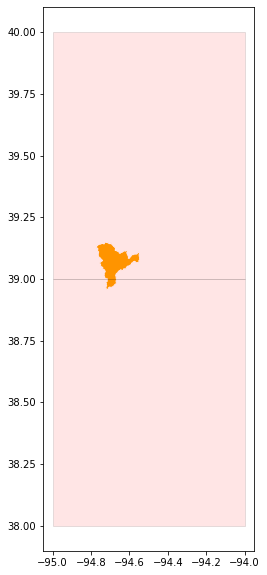

In [15]:
#plot
fix1, ax1 = plt.subplots(figsize=(30,10))
aoi.to_crs(gdf_dem.crs).plot(ax = ax1, color = 'orange', edgecolor = 'white')
gdf_dem_reduced.plot(ax = ax1,color = 'red',edgecolor = 'black', alpha=0.1)
plt.show()

### Export metadata

In [16]:
meta = gdf_dem_reduced[['title','publicationDate','vendorMetaUrl','geometry']].to_file(vector_dir/f'DEM_metadata_{select_data}.shp')

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_148/174493256.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  meta = gdf_dem_reduced[['title','publicationDate','vendorMetaUrl','geometry']].to_file(vector_dir/f'DEM_metadata_{select_data}.shp')
[2025-08-13 18:47:35,635] [WARNING] [collection] : Normalized/laundered field name: 'publicationDate' to 'publicatio'
[2025-08-13 18:47:35,636] [WARNING] [collection] : Normalized/laundered field name: 'vendorMetaUrl' to 'vendorMeta'


### Download DEM Links 

In [17]:
#dem prefered format
DEM_format = 'TIFF' #other options are TIFF, IMG, ArcGrid

In [18]:
dem_links = []
dem_folder = []
raw_links = gdf_dem_reduced['urls'].to_list()
pub_date = gdf_dem_reduced['publicationDate'].to_list()

In [19]:
for entry, date in zip(raw_links,pub_date):
    if DEM_format in entry.keys(): ##updated to handle IMG, TIFF and ZIP files
        dem_links.append(entry[DEM_format])
        dem_folder.append(date)
    if 'varies' in entry.keys():
        dem_links.append(entry['varies'])
        dem_folder.append(date)

In [20]:
#curtis to update code to choose IMG if TIFF not available and then unzip the IMG files as part of the dem download function
##download
dems = dem_download(dem_links,outputs_dir,dem_folder,docker=pem)

Obtaining DEM 2 of 2
opening: https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n40w095/USGS_13_n40w095_20240228.tif
saving to: /home/data/Rasters/kc_debug/dem/2024-02-29/USGS_13_n40w095_20240228.tif


### Confirm RASTER coverage

In [21]:
raster_paths = []
raster_paths_all = glob.glob(str(raster_dir)+f'/dem/**/*.{DEM_format[:3].lower()}',recursive=True)
for rp in raster_paths_all:
    if rp.split('/')[-1] in dems:
        raster_paths.append(rp)

In [22]:
out_vrt = process_dems(raster_paths, select_data, projection, overwrite=True)

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[2025-08-13 18:59:47,478] [WARNING] [geodataframe] : Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


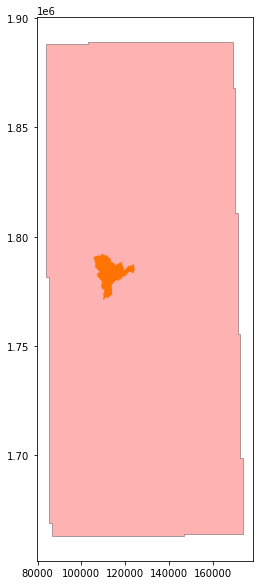

[2025-08-13 18:59:47,821] [INFO] [process_inputs] : coverage is 100.0 percent


In [23]:
covered = check_dem_coverage(out_vrt, huc_path, minimum_coverage = 0.8)

In [24]:
if not covered and auto_delete:
    shutil.rmtree(out_vrt.parent)
    print('DEM does not fully cover area of interest, specify next best DEM and rerun')

## End